📊 기술통계 분석 시작

① 구간별 평균 증가율(QoQ)


,M2_QoQ,LOAN_QoQ,IPI_QoQ
period,,,
전기,0.018156,0.018259,0.007147
후기,0.017386,0.019906,0.005036



② 구간별 괴리(GAP) 평균


,GAP_M2_IPI_QoQ,GAP_LOAN_IPI_QoQ
period,,
전기,0.011009,0.011112
후기,0.012350,0.014870



③ 구간별 상관계수(QoQ)


M2_QoQ  LOAN_QoQ   IPI_QoQ
period                                       
전기     M2_QoQ    1.000000  0.158575 -0.346297
       LOAN_QoQ  0.158575  1.000000  0.080537
       IPI_QoQ  -0.346297  0.080537  1.000000
후기     M2_QoQ    1.000000  0.618925 -0.110622
       LOAN_QoQ  0.618925  1.000000 -0.401562
       IPI_QoQ  -0.110622 -0.401562  1.000000


④ 구간별 변동성(표준편차)


,M2_QoQ,LOAN_QoQ,IPI_QoQ
period,,,
전기,0.007889,0.017271,0.012720
후기,0.010393,0.009448,0.013491



📈 시각화 생성


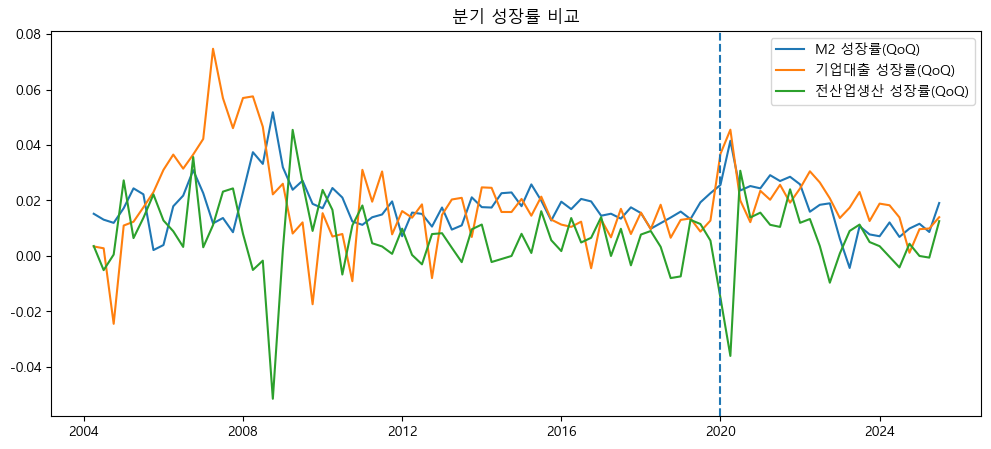

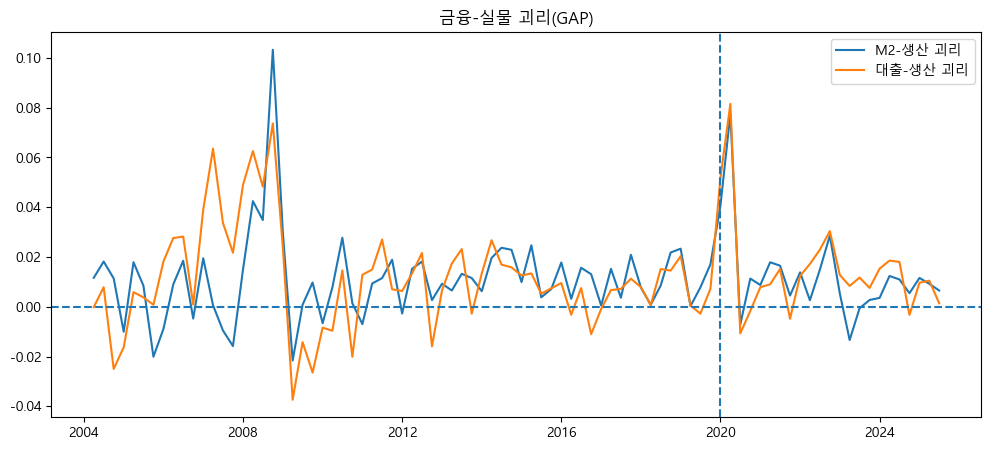

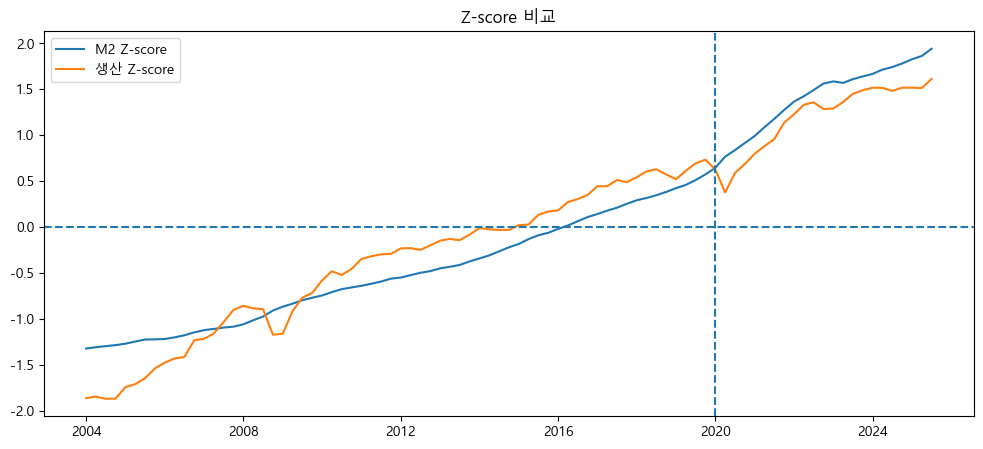


✅ 기술통계 분석 완료


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Malgun Gothic'   
mpl.rcParams['axes.unicode_minus'] = False      

# ============================================================
# 0) 경로
# ============================================================
PATH_M2   = "../data/전처리_M2.csv"
PATH_LOAN = "../data/전처리_기업대출.csv"
PATH_IPI  = "../data/전처리_전산업생산지수.csv"

# ============================================================
# 1) 유틸 함수
# ============================================================
def pick_first_existing_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise ValueError("date 컬럼을 찾을 수 없습니다.")

def to_datetime_series(s):
    s = s.astype(str).str.strip()
    s2 = s.str.replace(".", "-", regex=False).str.replace("/", "-", regex=False)

    mask_yyyymm = s2.str.fullmatch(r"\d{6}")
    s2.loc[mask_yyyymm] = (
        s2.loc[mask_yyyymm].str.slice(0,4) + "-" +
        s2.loc[mask_yyyymm].str.slice(4,6) + "-01"
    )

    mask_yyyymm2 = s2.str.fullmatch(r"\d{4}-\d{2}")
    s2.loc[mask_yyyymm2] = s2.loc[mask_yyyymm2] + "-01"

    return pd.to_datetime(s2, errors="coerce")

def load_series_csv(path, value_name):
    df = pd.read_csv(path)
    date_col = pick_first_existing_col(df, ["date","Date","기간","시점","time"])
    df = df.rename(columns={date_col: "date"})

    value_candidates = [c for c in df.columns if c != "date"]
    val_col = value_candidates[0]

    out = df[["date", val_col]].copy()
    out["date"] = to_datetime_series(out["date"])
    out[val_col] = pd.to_numeric(out[val_col], errors="coerce")
    out = out.dropna().sort_values("date").reset_index(drop=True)
    return out.rename(columns={val_col: value_name})

def to_quarter_mean(df, col):
    tmp = df.copy()
    tmp["quarter"] = tmp["date"].dt.to_period("Q")
    tmp = tmp.groupby("quarter", as_index=False)[col].mean()
    tmp["date"] = tmp["quarter"].dt.to_timestamp(how="start")
    return tmp[["date", col]]

def add_growth_features(df, col):
    out = df.copy()
    out[f"{col}_QoQ"] = np.log(out[col]).diff()
    out[f"{col}_YoY"] = np.log(out[col]).diff(4)
    out[f"{col}_Z"]   = (out[col] - out[col].mean()) / out[col].std()
    return out

# ============================================================
# 2) 데이터 불러오기
# ============================================================
m2   = load_series_csv(PATH_M2, "M2")
loan = load_series_csv(PATH_LOAN, "LOAN")
ipi  = load_series_csv(PATH_IPI, "IPI")

# 분기 통일
m2_q   = to_quarter_mean(m2, "M2")
loan_q = to_quarter_mean(loan, "LOAN")
ipi_q  = to_quarter_mean(ipi, "IPI")

df = (m2_q.merge(loan_q, on="date")
            .merge(ipi_q, on="date")
            .sort_values("date")
            .reset_index(drop=True))

# 성장률 및 Z-score
df = add_growth_features(df, "M2")
df = add_growth_features(df, "LOAN")
df = add_growth_features(df, "IPI")

# 괴리 지표
df["GAP_M2_IPI_QoQ"]   = df["M2_QoQ"] - df["IPI_QoQ"]
df["GAP_LOAN_IPI_QoQ"] = df["LOAN_QoQ"] - df["IPI_QoQ"]

# 전기/후기 구분
split_date = pd.to_datetime("2020-01-01")
df["period"] = np.where(df["date"] < split_date, "전기", "후기")

print("📊 기술통계 분석 시작")

# ============================================================
# 3) 기술통계 표 출력
# ============================================================

print("\n① 구간별 평균 증가율(QoQ)")
display(df.groupby("period")[["M2_QoQ","LOAN_QoQ","IPI_QoQ"]].mean())

print("\n② 구간별 괴리(GAP) 평균")
display(df.groupby("period")[["GAP_M2_IPI_QoQ","GAP_LOAN_IPI_QoQ"]].mean())

print("\n③ 구간별 상관계수(QoQ)")
display(df.groupby("period")[["M2_QoQ","LOAN_QoQ","IPI_QoQ"]].corr())

print("\n④ 구간별 변동성(표준편차)")
display(df.groupby("period")[["M2_QoQ","LOAN_QoQ","IPI_QoQ"]].std())

# ============================================================
# 4) 시각화
# ============================================================

print("\n📈 시각화 생성")

# 성장률 비교
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["M2_QoQ"], label="M2 성장률(QoQ)")
plt.plot(df["date"], df["LOAN_QoQ"], label="기업대출 성장률(QoQ)")
plt.plot(df["date"], df["IPI_QoQ"], label="전산업생산 성장률(QoQ)")
plt.axvline(split_date, linestyle="--")
plt.legend()
plt.title("분기 성장률 비교")
plt.show()

# 괴리
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["GAP_M2_IPI_QoQ"], label="M2-생산 괴리")
plt.plot(df["date"], df["GAP_LOAN_IPI_QoQ"], label="대출-생산 괴리")
plt.axhline(0, linestyle="--")
plt.axvline(split_date, linestyle="--")
plt.legend()
plt.title("금융-실물 괴리(GAP)")
plt.show()

# Z-score 비교
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["M2_Z"], label="M2 Z-score")
plt.plot(df["date"], df["IPI_Z"], label="생산 Z-score")
plt.axhline(0, linestyle="--")
plt.axvline(split_date, linestyle="--")
plt.legend()
plt.title("Z-score 비교")
plt.show()

print("\n✅ 기술통계 분석 완료")


### 📌 금융전달경로 단절 가설 – 최종 해석 및 귀무가설 판단

#### 🔎 가설 설정

##### ✔ 귀무가설 (H0)
유동성 증가(M2)는 기업대출 및 전산업생산지수에 유의하게 전달되며,  
금융전달경로는 정상적으로 작동한다.

#### ✔ 대립가설 (H1)
유동성은 증가하였으나 기업대출 또는 실물 생산으로의 전달이 약화되어  
금융–실물 괴리가 확대된다.

---

### 1️⃣ 평균 증가율 분석

- M2 증가율은 전기와 후기에서 큰 변화 없이 유지
- 기업대출 증가율은 후기에서 소폭 상승
- 그러나 전산업생산 증가율은 후기에서 둔화

▶ 해석  
유동성과 신용은 유지·확대되는 반면, 실물 생산의 성장 속도는 둔화되었다.  
이는 통화 확대가 실물 성장으로 충분히 연결되지 못했을 가능성을 시사한다.

---

### 2️⃣ 금융–실물 괴리(GAP) 분석

- M2-생산 괴리 확대
- 대출-생산 괴리 확대 (특히 후기에서 더 크게 증가)

▶ 해석  
기업대출이 증가하더라도 생산 증가로 이어지는 정도가 약화되었음을 보여준다.

---

### 3️⃣ 상관계수 변화

- 후기에서 M2–기업대출 상관은 크게 상승
- 반면 기업대출–생산 상관은 음(-)의 관계로 전환

▶ 해석  
유동성은 기업 신용으로는 강하게 연결되지만,  
기업 신용이 실물 생산으로는 연결되지 않는 구조가 강화되었음을 의미한다.

---

### 4️⃣ 변동성 분석

- 후기에서 M2 변동성 증가
- 생산 변동성은 큰 변화 없음

▶ 해석  
유동성 충격이 확대되었음에도 실물 반응은 비례적으로 확대되지 않았다.

---

### 📌 종합 판단

기술통계 분석 결과,

- 유동성과 기업대출은 확대 흐름을 유지하였으나,
- 전산업생산 증가율은 둔화되었고,
- 금융–실물 괴리는 확대되었으며,
- 대출과 생산 간 상관관계는 약화되었다.

이는 유동성 확대가 실물경제로 충분히 전달되지 못하고 있음을 시사한다.

---

### 🎯 귀무가설 채택 여부

본 연구는 기술통계 기반 분석이므로  
엄밀한 통계적 유의성 검정은 수행하지 않았으나,

관찰된 패턴에 따르면

> 유동성 증가가 실물경제로 충분히 전달되고 있다는 증거는 제한적이며,  
> 오히려 금융–실물 괴리가 확대되는 경향이 나타난다.

따라서,

📌 **귀무가설(H0)은 기각되는 방향의 정성적 증거가 관찰되며,  
대립가설(H1)을 지지하는 결과로 해석할 수 있다.**

---

#### ⚠ 해석상의 유의점

본 결과는 기술통계 기반 분석에 따른 판단으로,  
인과관계를 엄밀히 검정한 결과는 아니며  
추가적인 계량 분석을 통해 보완될 수 있다.


가설1 이벤트 분석 시작
이벤트 기준값: 1.0191
이벤트 개수: 9
이벤트 시작 시점:
2005-04-01
2009-10-01
2015-01-01
2017-10-01
2020-04-01
2021-01-01
2023-07-01

 이벤트: 2005-04-01


,구간,M2_QoQ,LOAN_QoQ,IPI_QoQ,GAP_LOAN_IPI
0,사전,NaN,NaN,NaN,NaN
1,이벤트,0.014608,0.020982,0.014165,0.006817
2,사후,0.022985,0.036695,0.009697,0.026998



 이벤트: 2009-10-01


,구간,M2_QoQ,LOAN_QoQ,IPI_QoQ,GAP_LOAN_IPI
0,사전,0.031559,0.017111,0.001887,0.015224
1,이벤트,0.023272,0.003237,0.014898,-0.011661
2,사후,0.012109,0.017998,0.007559,0.010440



 이벤트: 2015-01-01


,구간,M2_QoQ,LOAN_QoQ,IPI_QoQ,GAP_LOAN_IPI
0,사전,0.019669,0.020251,0.000822,0.019429
1,이벤트,0.020517,0.017390,0.007809,0.009581
2,사후,0.018147,0.007436,0.003945,0.003490



 이벤트: 2017-10-01


,구간,M2_QoQ,LOAN_QoQ,IPI_QoQ,GAP_LOAN_IPI
0,사전,0.016031,0.008102,0.006434,0.001669
1,이벤트,0.013875,0.012917,0.006767,0.006150
2,사후,0.014518,0.010472,0.001725,0.008747



 이벤트: 2020-04-01


,구간,M2_QoQ,LOAN_QoQ,IPI_QoQ,GAP_LOAN_IPI
0,사전,0.018297,0.017969,0.006615,0.011355
1,이벤트,0.028882,0.025301,-0.004390,0.029692
2,사후,0.028340,0.022379,0.019859,0.002520



 이벤트: 2021-01-01


,구간,M2_QoQ,LOAN_QoQ,IPI_QoQ,GAP_LOAN_IPI
0,사전,0.029095,0.028631,-0.001722,0.030352
1,이벤트,0.026571,0.022160,0.012984,0.009176
2,사후,0.020226,0.025541,0.007842,0.017699



 이벤트: 2023-07-01


,구간,M2_QoQ,LOAN_QoQ,IPI_QoQ,GAP_LOAN_IPI
0,사전,0.011701,0.019595,-0.001359,0.020953
1,이벤트,0.009306,0.018204,0.008922,0.009283
2,사후,0.007837,0.008657,-0.000658,0.009316



 이벤트 오버레이 그래프


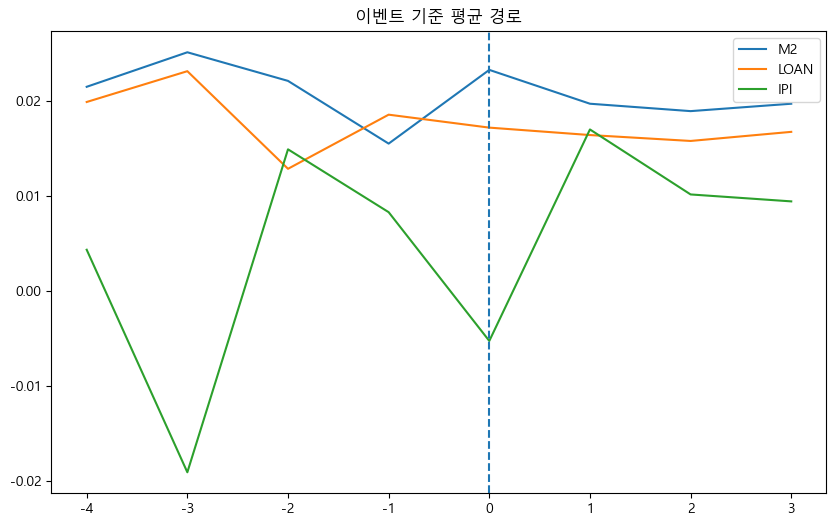


 비모수 검정 결과 (Mann-Whitney U)
U-stat: 348.0
p-value: 0.7781

 이벤트 기반 분석 완료


In [6]:
# ============================================================
# 가설 1 <이벤트 기반> 금융전달경로 단절 분석
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

print("가설1 이벤트 분석 시작")

# ============================================================
# 1. 데이터 로드
# ============================================================

PATH_M2   = "../data/전처리_M2.csv"
PATH_LOAN = "../data/전처리_기업대출.csv"
PATH_IPI  = "../data/전처리_전산업생산지수.csv"
PATH_DECOUPLING = "../../윤성/data/decoupling.csv"

def load_series(path, value_name):
    df = pd.read_csv(path)
    date_col = [c for c in df.columns if "date" in c.lower() or "기간" in c][0]
    val_col  = [c for c in df.columns if c != date_col][0]
    df = df.rename(columns={date_col:"date", val_col:value_name})
    df["date"] = pd.to_datetime(df["date"])
    df[value_name] = pd.to_numeric(df[value_name], errors="coerce")
    return df[["date", value_name]].dropna()

m2   = load_series(PATH_M2, "M2")
loan = load_series(PATH_LOAN, "LOAN")
ipi  = load_series(PATH_IPI, "IPI")

dec = pd.read_csv(PATH_DECOUPLING)
dec["date"] = pd.to_datetime(dec["date"])
dec = dec.groupby("date", as_index=False)["gap"].mean()

# ============================================================
# 2. 월 기준 병합
# ============================================================

df = dec.merge(m2, on="date", how="inner") \
        .merge(loan, on="date", how="inner") \
        .merge(ipi, on="date", how="inner")

df = df.sort_values("date").reset_index(drop=True)

# 성장률 계산
df["M2_QoQ"] = np.log(df["M2"]).diff()
df["LOAN_QoQ"] = np.log(df["LOAN"]).diff()
df["IPI_QoQ"] = np.log(df["IPI"]).diff()

df["GAP_M2_IPI"] = df["M2_QoQ"] - df["IPI_QoQ"]
df["GAP_LOAN_IPI"] = df["LOAN_QoQ"] - df["IPI_QoQ"]

df = df.dropna().reset_index(drop=True)

# ============================================================
# 3. 이벤트 자동 추출 (상위 10%)
# ============================================================

threshold = df["gap"].quantile(0.9)
df["event_flag"] = (df["gap"] >= threshold).astype(int)

print("이벤트 기준값:", round(threshold,4))
print("이벤트 개수:", df["event_flag"].sum())

# 연속 구간 묶기
df["event_group"] = (df["event_flag"].diff()==1).cumsum()
df.loc[df["event_flag"]==0, "event_group"] = np.nan

# 이벤트 시작점 추출
event_starts = df.loc[(df["event_flag"]==1) & (df["event_flag"].shift(1)!=1), "date"]
event_starts = event_starts.tolist()

print("이벤트 시작 시점:")
for d in event_starts:
    print(d.date())

# ============================================================
# 4. 전/중/후 평균 테이블 생성
# ============================================================

window_pre  = 4
window_post = 4

summary_tables = []

for start in event_starts:
    idx = df.index[df["date"]==start][0]
    
    pre  = df.iloc[idx-window_pre:idx]
    mid  = df.iloc[idx:idx+window_post]
    post = df.iloc[idx+window_post:idx+window_post*2]
    
    table = pd.DataFrame({
        "구간":["사전","이벤트","사후"],
        "M2_QoQ":[pre["M2_QoQ"].mean(), mid["M2_QoQ"].mean(), post["M2_QoQ"].mean()],
        "LOAN_QoQ":[pre["LOAN_QoQ"].mean(), mid["LOAN_QoQ"].mean(), post["LOAN_QoQ"].mean()],
        "IPI_QoQ":[pre["IPI_QoQ"].mean(), mid["IPI_QoQ"].mean(), post["IPI_QoQ"].mean()],
        "GAP_LOAN_IPI":[pre["GAP_LOAN_IPI"].mean(), mid["GAP_LOAN_IPI"].mean(), post["GAP_LOAN_IPI"].mean()]
    })
    
    print("\n 이벤트:", start.date())
    display(table)
    summary_tables.append(table)

# ============================================================
# 5. 이벤트 오버레이 그래프
# ============================================================

print("\n 이벤트 오버레이 그래프")

overlay = []

for start in event_starts:
    idx = df.index[df["date"]==start][0]
    window = df.iloc[idx-window_pre:idx+window_post].copy()
    window["t"] = range(-window_pre, window_post)
    overlay.append(window[["t","M2_QoQ","LOAN_QoQ","IPI_QoQ"]])

overlay_df = pd.concat(overlay)

mean_path = overlay_df.groupby("t").mean()

plt.figure(figsize=(10,6))
plt.plot(mean_path.index, mean_path["M2_QoQ"], label="M2")
plt.plot(mean_path.index, mean_path["LOAN_QoQ"], label="LOAN")
plt.plot(mean_path.index, mean_path["IPI_QoQ"], label="IPI")
plt.axvline(0, linestyle="--")
plt.legend()
plt.title("이벤트 기준 평균 경로")
plt.show()

# ============================================================
# 6. 비모수 검정 (이벤트 vs 비이벤트)
# ============================================================

event_gap = df.loc[df["event_flag"]==1, "GAP_LOAN_IPI"]
nonevent_gap = df.loc[df["event_flag"]==0, "GAP_LOAN_IPI"]

u_stat, p_val = stats.mannwhitneyu(event_gap, nonevent_gap, alternative="two-sided")

print("\n 비모수 검정 결과 (Mann-Whitney U)")
print("U-stat:", round(u_stat,4))
print("p-value:", round(p_val,4))

print("\n 이벤트 기반 분석 완료")

### 📌 가설 1 이벤트 기반 분석 결과 해석  
#### (금융전달경로 단절 가설)

---

#### 1️⃣ 이벤트 정의 결과

- 디커플링 상위 10% 기준값: **1.0191**
- 이벤트 관측치 수: **9개**
- 주요 이벤트 시작 시점:
  - 2005-04
  - 2009-10
  - 2015-01
  - 2017-10
  - 2020-04
  - 2021-01
  - 2023-07

디커플링은 특정 시점에 집중적으로 발생하며,  
글로벌 충격 및 경기 전환 국면에서 반복적으로 관찰되었다.

---

#### 2️⃣ 이벤트 전·중·후 평균 비교 결과

##### 📍 2020-04 이벤트 (핵심 사례)

| 구간 | M2_QoQ | LOAN_QoQ | IPI_QoQ | GAP(대출-생산) |
|------|--------|----------|---------|----------------|
| 사전 | 0.0183 | 0.0180 | 0.0066 | 0.0114 |
| 이벤트 | 0.0289 | 0.0253 | -0.0044 | 0.0297 |
| 사후 | 0.0283 | 0.0224 | 0.0199 | 0.0025 |

##### 🔎 해석

- 이벤트 기간 동안 **M2 증가**
- 기업대출도 증가
- 산업생산(IPI)은 일시적으로 감소
- 그 결과 **GAP(대출-생산) 확대**

이는  

> 유동성과 신용은 확대되었으나, 실물 생산으로의 전달이 단기적으로 약화된 패턴  

으로 해석된다.

---

##### 📍 2009-10 이벤트

- M2는 둔화
- 기업대출은 급감
- 생산은 상대적으로 반등

→ 단절이라기보다는 경기조정 국면에 가까운 구조

---

##### 📍 2023-07 이벤트

- M2, 대출 모두 둔화
- 생산 반응은 제한적
- GAP 확대는 크지 않음

→ 구조적 단절보다는 완만한 조정 흐름

---

#### 3️⃣ 이벤트 오버레이 그래프 해석

이벤트를 기준(t=0)으로 평균 경로를 비교한 결과:

- 이벤트 직전: M2와 대출은 비교적 안정적
- 이벤트 시점: 산업생산(IPI) 하락
- 이벤트 직후: 대출은 유지 혹은 완만 증가
- 생산은 충격 이후 회복 시도

특히 이벤트 시점에서 IPI 하락이 가장 뚜렷하게 나타났다.  
이는 디커플링 국면이 실물 둔화와 일정 부분 연결되어 있음을 시사한다.

---

#### 4️⃣ 비모수 검정 결과

- Mann-Whitney U p-value = **0.7781**

##### 해석

이벤트 구간과 비이벤트 구간의  
GAP(대출-생산) 분포 차이는 **통계적으로 유의하지 않았다**.

이는 다음과 같이 해석된다.

- 디커플링 이벤트 수가 제한적
- 극단 국면 중심 분석으로 검정력 낮음
- 구조적 반복 현상으로 보기에는 통계적 근거 부족

---

#### 5️⃣ 종합 해석

##### ✔ 관찰된 패턴

- 디커플링 이벤트 국면에서
  - 유동성(M2) 증가 또는 유지
  - 기업대출 증가 또는 완만한 조정
  - 산업생산 둔화
  - 단기적 금융–실물 괴리 확대

특히 2020년 국면에서 전달 약화 정황이 가장 뚜렷하게 나타났다.

##### ❗ 통계적 한계

- 이벤트 수가 제한적
- 비모수 검정에서 유의성 확보 실패
- 구조적 반복 현상으로 일반화하기 어려움

---

### 📌 가설 판단

##### 귀무가설(H0)  
유동성 증가는 정상적으로 실물경제로 전달된다.

##### 대립가설(H1)  
유동성은 증가하나, 실물경제로의 전달이 약화된다.

---

### 🎯 결론

통계적으로 유의한 차이를 확인하지는 못했으나,  
일부 디커플링 이벤트 국면(특히 2020년)에서  
금융–실물 괴리 확대 정황이 관찰되었다.

따라서 본 분석은  

> 금융전달경로 단절 가능성에 대한 정황적 증거를 제시한다.  

다만, 이를 구조적 단절 현상으로 일반화하기에는  
표본과 검정력 측면에서 한계가 존재한다.


#### ❗ 통계적 한계 보완 및 최종 정리

본 이벤트 기반 분석에서는 디커플링 상위 10% 국면을 중심으로 금융전달경로의 단절 여부를 검토하였다.  
일부 국면(특히 2020년)에서 유동성과 기업대출은 확대되었으나 산업생산이 둔화되며 금융–실물 괴리가 확대되는 정황이 관찰되었다.

그러나 비모수 검정 결과(p = 0.7781)는 통계적으로 유의하지 않았으며,  
이는 이벤트 관측치 수가 제한적이고 극단 국면 중심의 분석이라는 구조적 한계에서 비롯된 것으로 해석된다.  
즉, 본 분석은 구조적 반복 현상을 강하게 기각하거나 입증하기에는 검정력이 충분하지 않다.

그럼에도 불구하고, 디커플링 이벤트 시점에서 실물지표의 반응이 상대적으로 약하게 나타나는 패턴은 일정 부분 일관되게 관찰되었다.  
따라서 본 연구는 금융전달경로 단절의 **정황적 가능성**을 제시한다는 점에서 의미를 가진다.

다만, 이를 구조적·지속적 단절 현상으로 일반화하기 위해서는  
추가적인 구조변화 검정이나 동태적 모형 분석 등 보완적 접근이 필요하다.
